# Notebook configuration

In [9]:
run_numbers    = 4119, 4124#XXXX, YYYY, ZZZZ, TTTT
save_plots     = False
outputfolder   = "plots/corrections/"
inputfilenames = list(map("run{}_corrections.h5".format, run_numbers))

# XY map merger

In [10]:
import os
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.reco.dst_io         as dstio
import invisible_cities.reco.corrections    as corrf

from icaro.core.hst_functions import hist
from icaro.core.hst_functions import hist2d
from icaro.core.hst_functions import pdf
from icaro.core.hst_functions import labels
from icaro.core.hst_functions import scatter
from icaro.core.hst_functions import hist2d_profile
from icaro.core.hst_functions import covariance
from icaro.core.hst_functions import resolution
from icaro.core.hst_functions import gausstext
from icaro.core.hst_functions import save_to_folder

pi   = np.pi
save = functools.partial(save_to_folder, outputfolder) if save_plots else lambda *x: None

Running on  Tue May 30 16:12:48 2017


In [11]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

In [12]:
xy_maps = list(map(dstf.load_xy_corrections, inputfilenames))

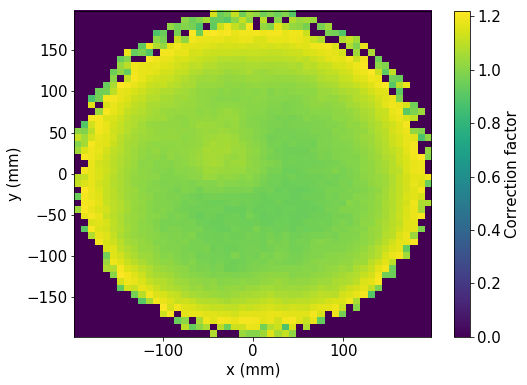

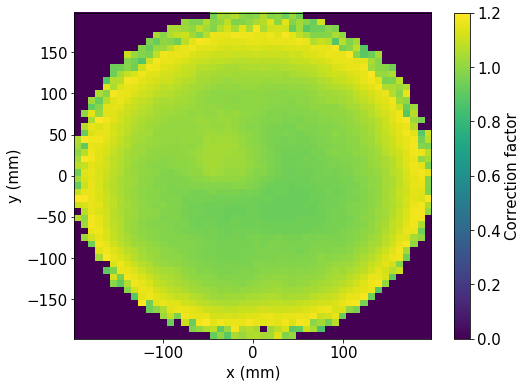

In [20]:
for xy_map in xy_maps:
    x , y  = xy_map._xs
    x0, y0 = np.min(x) - np.diff(x)[0]/2, np.min(y) - np.diff(y)[0]/2
    x1, y1 = np.max(x) + np.diff(x)[0]/2, np.max(y) + np.diff(y)[0]/2
    f      = xy_map._fs
    x, y   = np.repeat(x, y.size), np.tile(y, x.size)

    hist2d(x, y, f.shape, ((x0, x1), (y0, y1)), weights=f.flatten())
    plt.colorbar().set_label("Correction factor")
    labels("x (mm)", "y (mm)")

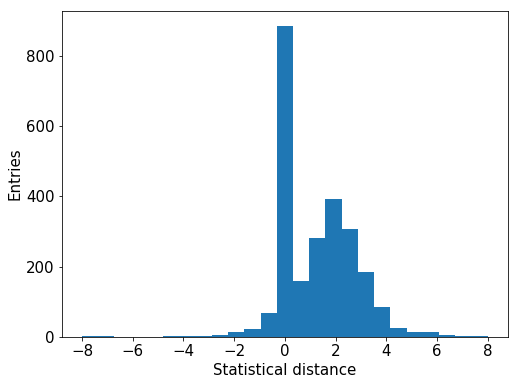

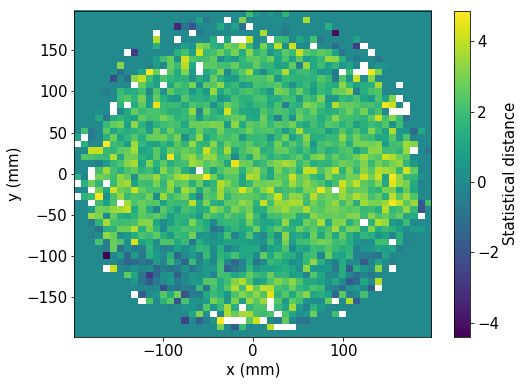

In [42]:
x , y  = xy_maps[1]._xs
x0, y0 = np.min(x) - np.diff(x)[0]/2, np.min(y) - np.diff(y)[0]/2
x1, y1 = np.max(x) + np.diff(x)[0]/2, np.max(y) + np.diff(y)[0]/2
f      = (xy_maps[0]._fs - xy_maps[1]._fs) /(xy_maps[0]._us**2 - xy_maps[1]._us**2)**0.5

not_valid    = np.isnan(f) | (xy_maps[0]._us == 0) | (xy_maps[1]._us == 0)
f[not_valid] = 0
x, y         = np.repeat(x, y.size), np.tile(y, x.size)

hist(f.flatten(), 25, (-8, 8))
labels("Statistical distance", "Entries")

hist2d(x, y, f.shape, ((x0, x1), (y0, y1)), weights=f.flatten(), cmin=-5, cmax=5)
plt.colorbar().set_label("Statistical distance")
labels("x (mm)", "y (mm)")

In [ ]:
def get_us(C):
    return C._us


def get_ws(U):
    W = 1/U**2
    W[U==0] = 0
    return W


def norm_ws(ws):
    sums    = np.sum(np.stack(ws), axis=0)
    norm_ws = ws / sums
    norm_ws[:, sums==0] = 0
    return norm_ws


def get_weights(corrs):
    us = list(map(get_us, corrs))
    ws = list(map(get_ws,    us))
    return norm_ws (ws)


def merge_maps(*maps):
    merged_map = np.zeros_like(maps[0]._fs)
    weights = map(sigma_to_weight, map(get_us, maps))
    factors = np.sum()